In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, rank, countDistinct, count
from pyspark.sql.window import Window
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
#creating the sparksesson object
spark = SparkSession.builder.appName('loan_recommendation_with_clusters').config("spark.driver.memory", "15g").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/08 14:30:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# printing the spark object to view spark config and getting url for spark UI (if needed)
spark

In [4]:
# importing the csv file using the spark object
loans_df = spark.read.csv("df_data/df_created_.csv", inferSchema=True, header=True)
# printing the schema(like DB structure) of imported csv dataset. 
loans_df.printSchema()

root
 |-- Min_IT_Loan_ID__c: double (nullable = true)
 |-- Opp_Number__c: double (nullable = true)
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: double (nullable = true)
 |-- Num_Of_Loans_Paid__c: double (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: double (nullable = true)
 |-- Amount: double (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: double (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- LoanIdFormat: integer (nullable = true)



In [5]:
# printing the first 10 rows of the selected columns i.e."LoanIdFormat","Amount","Total_Repayments__c","Payment_Frequency__c","count"
loans_df.select(["LoanIdFormat","Amount","Total_Repayments__c","Payment_Frequency__c","count"]).show(10)

+------------+------+-------------------+--------------------+-----+
|LoanIdFormat|Amount|Total_Repayments__c|Payment_Frequency__c|count|
+------------+------+-------------------+--------------------+-----+
|           1|1250.0|                4.0|             Monthly|    0|
|           1|2050.0|                5.0|             Monthly|    5|
|           1|2050.0|                4.0|             Monthly|    5|
|           1|2050.0|                5.0|             Monthly|    5|
|           1|2000.0|                2.0|             Monthly|    5|
|           1|2050.0|                4.0|             Monthly|    5|
|           1|2000.0|                4.0|             Monthly|    4|
|           1|2050.0|                4.0|             Monthly|    4|
|           1|2100.0|                4.0|             Monthly|    4|
|           1|2050.0|                5.0|             Monthly|    4|
+------------+------+-------------------+--------------------+-----+
only showing top 10 rows



In [6]:
# printing the description of few columns to get their insight desc. 
#      like 
#          no.of rows, 
#          mean of the value of column, 
#          standard deviation value, 
#          min and max values in columns
loans_df.select(["LoanIdFormat","count","Amount","Total_Repayments__c","Number_Of_Loans_Granted__c","Num_Of_Loans_Paid__c"]).describe().show()

24/01/08 14:31:13 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+-----------------+-------------------+--------------------------+--------------------+
|summary|      LoanIdFormat|             count|           Amount|Total_Repayments__c|Number_Of_Loans_Granted__c|Num_Of_Loans_Paid__c|
+-------+------------------+------------------+-----------------+-------------------+--------------------------+--------------------+
|  count|             17079|             17079|            17079|              17079|                     17079|               17079|
|   mean|14.728731190350723|1.3821066807190117|1857.020317348791| 11.395222202705076|         13.64113823994379|  11.025001463785935|
| stddev|13.210237567953197|0.9665433779775973|1450.436334960087|  7.472509833818936|         9.490984548297364|    9.27097352040766|
|    min|                 1|                 0|            100.0|                1.0|                       5.0|                 3.0|
|    max|                60|                 7|           5000

### Plotting the histogram to view that is our counts(rating) were distributed in binomial or normal distribution

In [7]:
# converting the spark dataframe into the pandas dataframe to print the 
hist_data  = loans_df.select("count").toPandas()

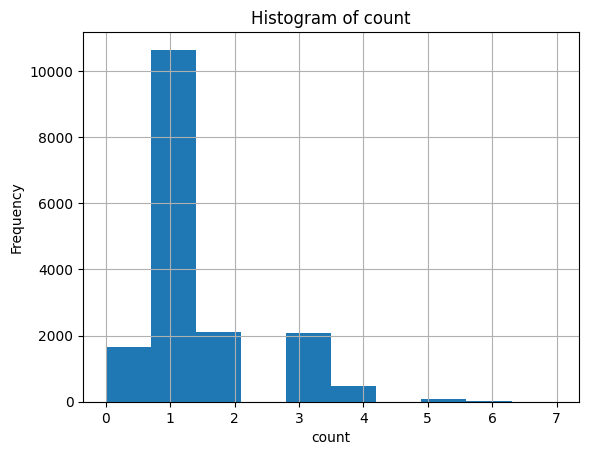

In [8]:
# Creating the histograms for the column "count" 
hist_data['count'].hist()
plt.xlabel("count")
plt.ylabel("Frequency")
plt.title(f"Histogram of count")
plt.show()

######

#### from the above histogram we see that data count(ratings) of loans is not normally distributed

In [9]:
# Count the number of unique loan items (created using cluster technique)
num_unique_loan_id_format = loans_df.select('LoanIdFormat').distinct().count()
print(f"Number of unique loanId_format(created using cluster technique): {num_unique_loan_id_format}")

# Count the number of unique loan id's
num_unique_id = loans_df.select('Id').distinct().count()
print(f"Number of unique Loan Id: {num_unique_id}")

Number of unique loanId_format(created using cluster technique): 43
Number of unique Loan Id: 10576


In [10]:
# Count the number of unique users
tmp = loans_df.select('userId').distinct().count()
print(f"Number of unique users: {tmp}")


Number of unique users: 8179


In [11]:
# distinct values of the rating
loans_df.select("count").distinct().show()

+-----+
|count|
+-----+
|    1|
|    6|
|    3|
|    5|
|    4|
|    7|
|    2|
|    0|
+-----+



========================================================================================================

Converting the dataset into train test and validation split.

In [12]:
# just taking a look of dataset by selecting 3 columns "LoanIdFormat","count","Amount"  and showing its 10 rows
loans_df.select(["LoanIdFormat","count","Amount"]).show(10)

+------------+-----+------+
|LoanIdFormat|count|Amount|
+------------+-----+------+
|           1|    0|1250.0|
|           1|    5|2050.0|
|           1|    5|2050.0|
|           1|    5|2050.0|
|           1|    5|2000.0|
|           1|    5|2050.0|
|           1|    4|2000.0|
|           1|    4|2050.0|
|           1|    4|2100.0|
|           1|    4|2050.0|
+------------+-----+------+
only showing top 10 rows



In [13]:
# breaking the dataframe into train and validation using randomsplit method we are converting it into the ratio of 80%,20%
train, validation = loans_df.randomSplit([0.8, 0.2])
# train, validation, test = loans_df.randomSplit([0.8, 0.1, 0.1])
# # cache data
train.cache()
validation.cache()
# test.cache()

DataFrame[Min_IT_Loan_ID__c: double, Opp_Number__c: double, Id: string, AccountID: string, Number_Of_Loans_Granted__c: double, Num_Of_Loans_Paid__c: double, Purpose_of_Loan__c: string, Total_Repayments__c: double, Amount: double, Term_in_Weeks__c: double, Payment_Frequency__c: string, StageName: string, Applicant Age: double, userId: int, loanId: int, count: int, LoanIdFormat: int]

In [14]:
# printing the dataframe schema of loans_df
loans_df.printSchema()

root
 |-- Min_IT_Loan_ID__c: double (nullable = true)
 |-- Opp_Number__c: double (nullable = true)
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: double (nullable = true)
 |-- Num_Of_Loans_Paid__c: double (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: double (nullable = true)
 |-- Amount: double (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: double (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- LoanIdFormat: integer (nullable = true)



In [15]:
# creating the als model and priting the rmse to continuesly checking the error in model
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # Train the model using the training data
            als_model = ALS(maxIter=num_iters,regParam=reg, rank=rank,
                                        userCol='userId', itemCol='LoanIdFormat', ratingCol='count', seed=42,
                           coldStartStrategy="drop",nonnegative=True)
            model = als_model.fit(train_data)
            
            # Generate predictions on the test data
            predictions = model.transform(validation_data)
            predictions = predictions.withColumn("prediction", expr("CASE WHEN prediction < 0 THEN 0 WHEN prediction > 9 THEN 9 ELSE prediction END"))
            
            evaluator = RegressionEvaluator(metricName='rmse', labelCol='count', predictionCol='prediction')
            error = evaluator.evaluate(predictions)
            
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [16]:
# hyper-param config
num_iterations = 10
ranks = [8, 10, 20, 40, 60]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# train the ALS mode using grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

24/01/08 14:31:52 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


8 latent factors and regularization = 0.001: validation RMSE is 0.6098706548715608
8 latent factors and regularization = 0.01: validation RMSE is 0.44249295611761486
8 latent factors and regularization = 0.05: validation RMSE is 0.34518033666772624
8 latent factors and regularization = 0.1: validation RMSE is 0.32916890436177315
8 latent factors and regularization = 0.2: validation RMSE is 0.3740259378780205
10 latent factors and regularization = 0.001: validation RMSE is 0.6048671506795882
10 latent factors and regularization = 0.01: validation RMSE is 0.4724790383915554
10 latent factors and regularization = 0.05: validation RMSE is 0.35334296711425717
10 latent factors and regularization = 0.1: validation RMSE is 0.3356788470171454
10 latent factors and regularization = 0.2: validation RMSE is 0.3787991184937949
20 latent factors and regularization = 0.001: validation RMSE is 0.5736683456421454
20 latent factors and regularization = 0.01: validation RMSE is 0.4659381586600664
20 lat

In [17]:
# predicting the prdiction for the validation dataset to further compare our results 
predictions = final_model.transform(validation)
# also printing the schema of predictions 
predictions.printSchema()

root
 |-- Min_IT_Loan_ID__c: double (nullable = true)
 |-- Opp_Number__c: double (nullable = true)
 |-- Id: string (nullable = true)
 |-- AccountID: string (nullable = true)
 |-- Number_Of_Loans_Granted__c: double (nullable = true)
 |-- Num_Of_Loans_Paid__c: double (nullable = true)
 |-- Purpose_of_Loan__c: string (nullable = true)
 |-- Total_Repayments__c: double (nullable = true)
 |-- Amount: double (nullable = true)
 |-- Term_in_Weeks__c: double (nullable = true)
 |-- Payment_Frequency__c: string (nullable = true)
 |-- StageName: string (nullable = true)
 |-- Applicant Age: double (nullable = true)
 |-- userId: integer (nullable = true)
 |-- loanId: integer (nullable = true)
 |-- count: integer (nullable = true)
 |-- LoanIdFormat: integer (nullable = true)
 |-- prediction: float (nullable = false)



In [18]:
# printing the 25 rows with these columns "LoanIdFormat","loanId","userId","Amount","Total_Repayments__c","count","prediction" 
predictions.select(["LoanIdFormat","loanId","userId","Amount","Total_Repayments__c","count","prediction"]).show(25)

+------------+------+------+------+-------------------+-----+----------+
|LoanIdFormat|loanId|userId|Amount|Total_Repayments__c|count|prediction|
+------------+------+------+------+-------------------+-----+----------+
|          48|  6940|  8592|5000.0|               24.0|    0|       0.0|
|          11|  7657|  1580| 500.0|                5.0|    1| 0.9269398|
|          45| 12881|  5300|4000.0|               16.0|    2| 0.6666484|
|          11|  4062|  1580| 500.0|                8.0|    1| 0.9269398|
|           8| 13220|  7240| 500.0|                8.0|    1| 0.9398522|
|           6| 13295|  9900|2050.0|               16.0|    0|       0.0|
|           6|  4308|   833|2100.0|               16.0|    1| 0.9440525|
|          11|  4550|   496| 500.0|                7.0|    2| 1.8704993|
|          11|  4550|   496| 500.0|                7.0|    2| 1.8704993|
|           2|  4660|  2999|2000.0|                7.0|    0|0.73764795|
|           2|  5934|   243|2050.0|                

In [19]:
# printing the rows having the count column = 1 
predictions.filter(predictions["count"] == 1).select(["LoanIdFormat","loanId","userId","Amount","Total_Repayments__c","count","prediction"]).show(25)

+------------+------+------+------+-------------------+-----+----------+
|LoanIdFormat|loanId|userId|Amount|Total_Repayments__c|count|prediction|
+------------+------+------+------+-------------------+-----+----------+
|          11|  7657|  1580| 500.0|                5.0|    1| 0.9269398|
|          11|  4062|  1580| 500.0|                8.0|    1| 0.9269398|
|           8| 13220|  7240| 500.0|                8.0|    1| 0.9398522|
|           6|  4308|   833|2100.0|               16.0|    1| 0.9440525|
|          40|  6442|  4190|3500.0|                4.0|    1|0.92312634|
|          45|  8573|  4158|3500.0|               16.0|    1|  0.803948|
|          20|  9763|  7417|4500.0|               12.0|    1| 0.9414696|
|          20| 11074|  7417|5000.0|               12.0|    1| 0.9414696|
|          11| 13281|  8803| 500.0|                7.0|    1| 0.9352496|
|           8|  4427|  2811| 400.0|               10.0|    1|  0.936692|
|           2|  4447|  2580|2100.0|                

In [20]:
# printing the predictions which are grouped by the predictions.prediction  and then been counted and sorted
predictions.groupBy(predictions.prediction).count().sort(predictions.prediction).show(50)

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  117|
|0.15140757|    1|
|0.16094153|    1|
|0.17221467|    1|
|0.19338702|    1|
|0.21979342|    2|
|0.23560703|    1|
|0.24083233|    1|
|0.24275893|    1|
|0.26183456|    1|
|0.28541967|    2|
|0.30006102|    1|
| 0.3054843|    1|
|0.31921825|    1|
|0.32104948|    1|
|0.32743114|    1|
| 0.3437095|    1|
|  0.347981|    1|
|0.36293164|    1|
|0.36448207|    2|
|0.38553223|    1|
|0.40746307|    1|
|0.43449497|    1|
| 0.4444648|    1|
| 0.4520946|    1|
|0.45999876|    1|
|0.46128076|    2|
| 0.4640014|    1|
|0.46693772|    1|
| 0.4676248|    1|
|0.46810678|    2|
| 0.4707348|    1|
|0.48395893|    1|
|0.48470622|    1|
| 0.4885902|    1|
|0.51025593|    1|
| 0.5179157|    1|
|0.53820133|    1|
| 0.5389248|    2|
|0.54319805|    1|
|0.54360384|    4|
|0.55235684|    1|
|0.55354685|    3|
|0.55709505|    4|
| 0.5653591|    2|
| 0.5655438|    1|
|0.57183266|    2|
| 0.5792737|    1|
|0.57955647|    1|
|0.58630574|

In [21]:
# describing the predictions dataframe.
predictions.select("prediction","LoanIdFormat").describe().show()

+-------+------------------+------------------+
|summary|        prediction|      LoanIdFormat|
+-------+------------------+------------------+
|  count|              2268|              2268|
|   mean|  1.36372655529588|15.329805996472663|
| stddev|0.9025637698516951| 13.53280751307686|
|    min|               0.0|                 1|
|    max|          4.987998|                60|
+-------+------------------+------------------+



In [22]:
# applying the RegressionEvaluator and calculating the RMSE Error.
evaluator = RegressionEvaluator(metricName='rmse', labelCol='count', predictionCol='prediction')
error = evaluator.evaluate(predictions)

In [29]:
# The current Error int model is 0.32 
print(f"The RMSE for the above mnodel is : {error}")

The RMSE for the above mnodel is : 0.32916890436177315


In [24]:
userRecommends = final_model.recommendForAllUsers(5)
loanRecommends = final_model.recommendForAllItems(5)

In [25]:
loanRecommends.printSchema()

root
 |-- LoanIdFormat: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- userId: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [26]:
loanRecommends.select(["LoanIdFormat","recommendations.userId","recommendations.rating"]).show(10,truncate=False)

+------------+-----------------------------+-------------------------------------------------------+
|LoanIdFormat|userId                       |rating                                                 |
+------------+-----------------------------+-------------------------------------------------------+
|20          |[103, 1157, 1119, 1135, 1041]|[5.7448735, 5.6164837, 5.386318, 4.878138, 4.6188884]  |
|40          |[1119, 103, 1157, 1319, 1195]|[5.543774, 4.813971, 4.529651, 4.1789823, 3.9635503]   |
|10          |[146, 103, 1157, 1138, 1103] |[4.577943, 3.973205, 3.9213161, 3.690246, 3.5139546]   |
|60          |[103, 1157, 1119, 683, 1103] |[4.6026087, 4.4345584, 4.2404823, 3.8305702, 3.7627208]|
|30          |[103, 1157, 1119, 683, 106]  |[5.367736, 5.063975, 4.7354274, 4.4805274, 4.285919]   |
|31          |[1119, 1157, 103, 1135, 1237]|[5.2877893, 4.678157, 4.6301265, 4.307131, 4.137315]   |
|1           |[146, 37, 103, 1157, 539]    |[4.6647596, 4.5137315, 4.354322, 4.3258753, 3.9

In [27]:
userRecommends.printSchema()

root
 |-- userId: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- LoanIdFormat: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [28]:
userRecommends.select(["userId","recommendations.LoanIdFormat","recommendations.rating"]).show(50,truncate=False)

+------+--------------------+-----------------------------------------------------------+
|userId|LoanIdFormat        |rating                                                     |
+------+--------------------+-----------------------------------------------------------+
|1     |[3, 2, 51, 24, 29]  |[1.9949927, 1.8836088, 1.8757503, 1.8472228, 1.7957728]    |
|12    |[60, 57, 54, 48, 45]|[0.0, 0.0, 0.0, 0.0, 0.0]                                  |
|13    |[3, 11, 8, 2, 29]   |[1.9896698, 1.8704994, 1.859191, 1.8560055, 1.8143655]     |
|22    |[21, 6, 9, 11, 51]  |[2.334106, 2.0562449, 2.0454564, 2.0017724, 1.9772518]     |
|26    |[20, 26, 6, 5, 41]  |[2.9187407, 2.8707922, 2.7893574, 2.7843223, 2.7380717]    |
|27    |[9, 6, 12, 3, 8]    |[0.62669146, 0.620904, 0.6047225, 0.5928287, 0.56612486]   |
|28    |[12, 6, 9, 32, 39]  |[4.2800727, 4.0733447, 3.8145173, 3.7045434, 3.6552496]    |
|31    |[6, 12, 9, 3, 8]    |[2.8457656, 2.8267455, 2.8143127, 2.6687398, 2.560497]     |
|44    |[3

In [ ]:
userID                         = 182  
loanID                         = [6, 12, 9, 3, 2]  
loan_rating_prediction_percent = [3.7991424, 3.7227712, 3.715703, 3.7005975, 3.5835078]


Loan amount = 2050, 1000
Total_Repayments__c = 16, 10
applicanfiformat = 6, 9

6 -->  [11	19],[1200 2300]
9 -->  [8   18],[150  1350]




In [ ]:
userID                             = 133
loanID                             = [33, 20, 5, 41, 32]
loan_rating_prediction_percent     = [3.8928864, 3.7150927, 3.5364568, 3.4744163, 3.4208148] 

loan amount =  4500, 4400, 4450, 4400
Total repayment = 14 8 

33  [4 8]   [500]
20  [12 18] [4500 5000]



In [35]:
# loanRecommends.filter(loanRecommends.loanId == 59315 ).show(vertical=True,truncate=False)

In [ ]:
# this is created using the understaing of concept and code available on web (*** may contain some errors)
# Function to calculate MAP@K
def calculate_map_at_k(predictions, ground_truth, k):
    # Inner join to get the predicted ratings for relevant items
    joined_df = predictions.join(ground_truth, on="userId")
    # Sort recommendations by predicted rating in descending order
    window_spec = Window().partitionBy("userId").orderBy(col("count").desc())
    sorted_predictions = joined_df.select(
        "userId",
        "loanId",
        "prediction",
        expr("ROW_NUMBER() OVER (PARTITION BY userId ORDER BY count DESC) AS rank")
    ).filter(col("rank") <= k)
    # Calculate precision at each position
    precision_at_k = sorted_predictions.withColumn(
        "relevant_at_k", expr("CASE WHEN loanId IN (loanId) THEN (prediction) ELSE 0 END")
    ).groupBy("userId").agg(expr(f"SUM(relevant_at_k) / {k} AS precision_at_k"))
    # Calculate MAP@K
    map_at_k = precision_at_k.agg(expr("SUM(precision_at_k) / COUNT(userId) AS map_at_k")).collect()[0]["map_at_k"]
    return map_at_k

In [25]:
# Caling the map@k fucntion for k = 4 and k = 5 to evaluate the model
map_at_4 = calculate_map_at_k(predictions.select("Id","AccountID","prediction","LoanIdFormat","userId"), loans_df, k=4)
print(f"MAP@4: {map_at_4}")

MAP@4: 1.13766222328483


In [27]:
map_at_3 = calculate_map_at_k(predictions.select("Id","AccountID","prediction","LoanIdFormat","userId"), loans_df, k=3)
print(f"MAP@5: {map_at_3}")

MAP@5: 1.2443166616047456


In [26]:
map_at_5 = calculate_map_at_k(predictions.select("Id","AccountID","prediction","LoanIdFormat","userId"), loans_df, k=5)
print(f"MAP@5: {map_at_5}")

MAP@5: 1.0187143448191534
